In [ ]:
# !pip install gdown

In [1]:
# import gdown
# url = "https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&export=download&authuser=0"
# gdown.download(url, quiet=False)

In [2]:
# !unzip -q MSFD.zip

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torchvision.io import read_image
import cv2
import torchvision.transforms as transforms
import gc
from tqdm import tqdm

In [2]:
torch.manual_seed(123)

In [ ]:
# import tqdm

# # Calculate the mean and std of the dataset

# dataset_path = "MSFD/1/face_crop"
# means = []
# stds = []

# # Create a progress bar to track the process
# for img_file in tqdm.tqdm(os.listdir(dataset_path), desc="Processing Images"):
#     img_path = os.path.join(dataset_path, img_file)
#     # Use OpenCV to load the image
#     img = cv2.imread(img_path)
#     if img is not None:
#         # Convert BGR to RGB
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         # Calculate mean and std per channel and normalize to [0, 1]
#         means.append(np.mean(img, axis=(0, 1)) / 255.0)
#         stds.append(np.std(img, axis=(0, 1)) / 255.0)

# # Calculate overall mean and std across all images
# dataset_mean = np.mean(means, axis=0)
# dataset_std = np.mean(stds, axis=0)

# print(f"Dataset mean: {dataset_mean}")
# print(f"Dataset std: {dataset_std}")

In [ ]:
dataset_path = "MSFD/1"

class MSFDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, img_size=(128, 128)):
        self.dataset_path = dataset_path
        
        # Get all face image files
        face_dir = os.path.join(dataset_path, "face_crop")
        segmentation_dir = os.path.join(dataset_path, "face_crop_segmentation")
        
        # Only include images that have corresponding segmentation files
        self.image_files = []
        self.segmentation_files = []
        
        for img_name in os.listdir(face_dir):
            seg_name = img_name  # Matching segmentation should have same filename
            
            img_path = os.path.join(face_dir, img_name)
            seg_path = os.path.join(segmentation_dir, seg_name)
            
            # Only include if both files exist
            if os.path.exists(img_path) and os.path.exists(seg_path):
                self.image_files.append(img_name)
                self.segmentation_files.append(seg_name)
        
        self.img_size = img_size
        print(f"Found {len(self.image_files)} matched image-segmentation pairs")
        
        # Define transforms
        self.img_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.Normalize(mean=[0.52988076, 0.45696659, 0.43334861], std=[0.25698626, 0.23935081, 0.23180752])
        ])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image using OpenCV
        image_path = os.path.join(self.dataset_path, "face_crop", self.image_files[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        
        # Load segmentation using OpenCV
        segmentation_path = os.path.join(self.dataset_path, "face_crop_segmentation", self.segmentation_files[idx])
        segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize images to consistent size
        image = cv2.resize(image, self.img_size)
        segmentation = cv2.resize(segmentation, self.img_size, interpolation=cv2.INTER_NEAREST)
        
        # Convert to tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        segmentation = torch.tensor(segmentation, dtype=torch.long)
        
        # Apply normalization to image
        image = self.img_transform(image)
        
        return image, segmentation
    
dataset = MSFDDataset(dataset_path)

Found 9382 matched image-segmentation pairs


In [5]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

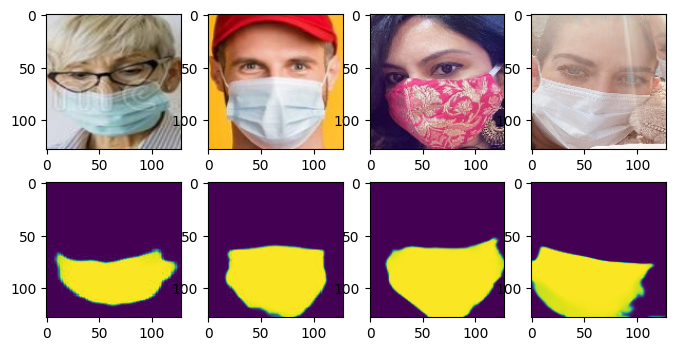

In [6]:
# Plot images and segmentations
import matplotlib.pyplot as plt

def plot_images(images, segmentations):
    fig, axs = plt.subplots(2, 4, figsize=(8, 4))
    for i in range(4):
        axs[0, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].imshow(segmentations[i].cpu().numpy())
    plt.show()

images, segmentations = next(iter(train_loader))

# Denormalize images
images = images * torch.tensor([0.25698626, 0.23935081, 0.23180752]).view(1, 3, 1, 1) + torch.tensor([0.52988076, 0.45696659, 0.43334861]).view(1, 3, 1, 1)
plot_images(images, segmentations)

In [7]:
# Define the U-Net model architecture for segmentation with hyperparameter flexibility
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=256, depth=4, filters_base=64, 
                 activation='relu', use_batchnorm=True, dropout_rate=0.0):
        super(UNet, self).__init__()
        
        self.depth = depth
        self.activation_name = activation
        self.use_batchnorm = use_batchnorm
        
        # Define activation function
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            self.activation = nn.ReLU(inplace=True)
            
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        
        # Create encoders, decoders, and upconv operations dynamically based on depth
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.upconvs = nn.ModuleList()
        
        # Create encoder blocks
        in_channels = n_channels
        for i in range(depth):
            out_channels = filters_base * (2**i)
            self.encoders.append(self._conv_block(in_channels, out_channels))
            in_channels = out_channels
            
        # Bottleneck
        bottleneck_channels = filters_base * (2**depth)
        self.bottleneck = self._conv_block(in_channels, bottleneck_channels)
        
        # Create decoder blocks
        in_channels = bottleneck_channels
        for i in range(depth):
            out_channels = filters_base * (2**(depth-i-1))
            self.upconvs.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2))
            self.decoders.append(self._conv_block(in_channels, out_channels))
            in_channels = out_channels
            
        # Final convolution
        self.final_conv = nn.Conv2d(filters_base, n_classes, kernel_size=1)
    
    def _conv_block(self, in_channels, out_channels):
        layers = []
        
        # First convolution
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        if self.use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        if self.dropout is not None:
            layers.append(self.dropout)
            
        # Second convolution
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        if self.use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        if self.dropout is not None:
            layers.append(self.dropout)
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Store encoder outputs for skip connections
        encoder_outputs = []
        
        # Encoding path
        for encoder in self.encoders:
            x = encoder(x)
            encoder_outputs.append(x)
            x = self.pool(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoding path with skip connections
        for i in range(self.depth):
            x = self.upconvs[i](x)
            skip_connection = encoder_outputs[self.depth - i - 1]
            
            # Handle the case where dimensions don't match exactly
            if x.shape != skip_connection.shape[2:]:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)
                
            x = torch.cat([x, skip_connection], dim=1)
            x = self.decoders[i](x)
        
        # Final convolution
        x = self.final_conv(x)
        
        return x

In [8]:
model = UNet(n_channels=3, n_classes=256, depth=3, filters_base=32, activation='leaky_relu', use_batchnorm=True, dropout_rate=0.05)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Define the training function that trains the model without any wandb logging
def train_model(model, device, optimizer, criterion, train_loader, val_loader, num_epochs):
    best_val_accuracy = 0

    # Training loop
    num_epochs = num_epochs
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        gc.collect()

        # Set model to training mode
        model.train()
        train_losses = []

        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        
        for data, targets in progress_bar:
            data = data.to(device)
            targets = targets.to(device)
            
            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)
            train_losses.append(loss.item())
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}"
            })
        
        # Calculate average training loss
        avg_train_loss = sum(train_losses) / len(train_losses)
        
        # Validation phase
        model.eval()
        val_losses = []
        num_correct = 0
        num_pixels = 0
        total_iou = 0
        total_dice = 0
        num_batches = 0

        val_bar = tqdm(val_loader, total=len(val_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        with torch.no_grad():
            for data, targets in val_bar:
                data = data.to(device)
                targets = targets.to(device)
                
                # Forward pass
                scores = model(data)
                loss = criterion(scores, targets)
                val_losses.append(loss.item())
                
                # Calculate accuracy
                _, predictions = scores.max(1)
                num_correct += (predictions == targets).sum().item()
                num_pixels += targets.numel()

                intersection = (predictions & targets).float().sum((1, 2))  # Pixels where prediction == target
                union = (predictions | targets).float().sum((1, 2)) + 1e-6  # Union of predicted and actual masks
                iou = (intersection / union).mean().item()

                dice_score = (2 * intersection / (predictions.float().sum((1, 2)) + targets.float().sum((1, 2)) + 1e-8)).mean().item()

                total_iou += iou
                total_dice += dice_score
                num_batches += 1

                val_bar.set_postfix({
                    "Val Loss": f"{loss.item():.4f}",
                    "IoU": f"{iou:.4f}",
                    "Dice": f"{dice_score:.4f}"
                })

            mean_iou = total_iou / num_batches
            mean_dice = total_dice / num_batches
                            
        # Calculate metrics
        val_accuracy = (num_correct / num_pixels)
        avg_val_loss = sum(val_losses) / len(val_losses)
        
        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation IoU: {mean_iou:.4f}")
        print(f"Validation Dice: {mean_dice:.4f}")
        
        # # Save best model
        # if val_accuracy > best_val_accuracy:
        #     best_val_accuracy = val_accuracy
        #     best_model_state = model.state_dict().copy()
        #     torch.save(model.state_dict(), f"best_model.pth")
        #     print(f"Saved best model with accuracy: {best_val_accuracy:.4f}")

        torch.cuda.empty_cache()
        gc.collect()

In [10]:
train_model(model, device, optimizer, criterion, train_loader, val_loader, num_epochs=2)

Epoch 1/2 [Validation]: 100%|██████████| 59/59 [00:03<00:00, 17.29it/s, Val Loss=0.9274, IoU=0.7826, Dice=0.8558]


Epoch 1/2
Training Loss: 2.1914
Validation Loss: 1.0206
Validation Accuracy: 0.8272
Validation IoU: 0.7988
Validation Dice: 0.8772


Epoch 2/2 [Validation]: 100%|██████████| 59/59 [00:03<00:00, 18.53it/s, Val Loss=0.7667, IoU=0.8565, Dice=0.9026]

Epoch 2/2
Training Loss: 0.9065
Validation Loss: 0.8667
Validation Accuracy: 0.8353
Validation IoU: 0.8753
Validation Dice: 0.9280


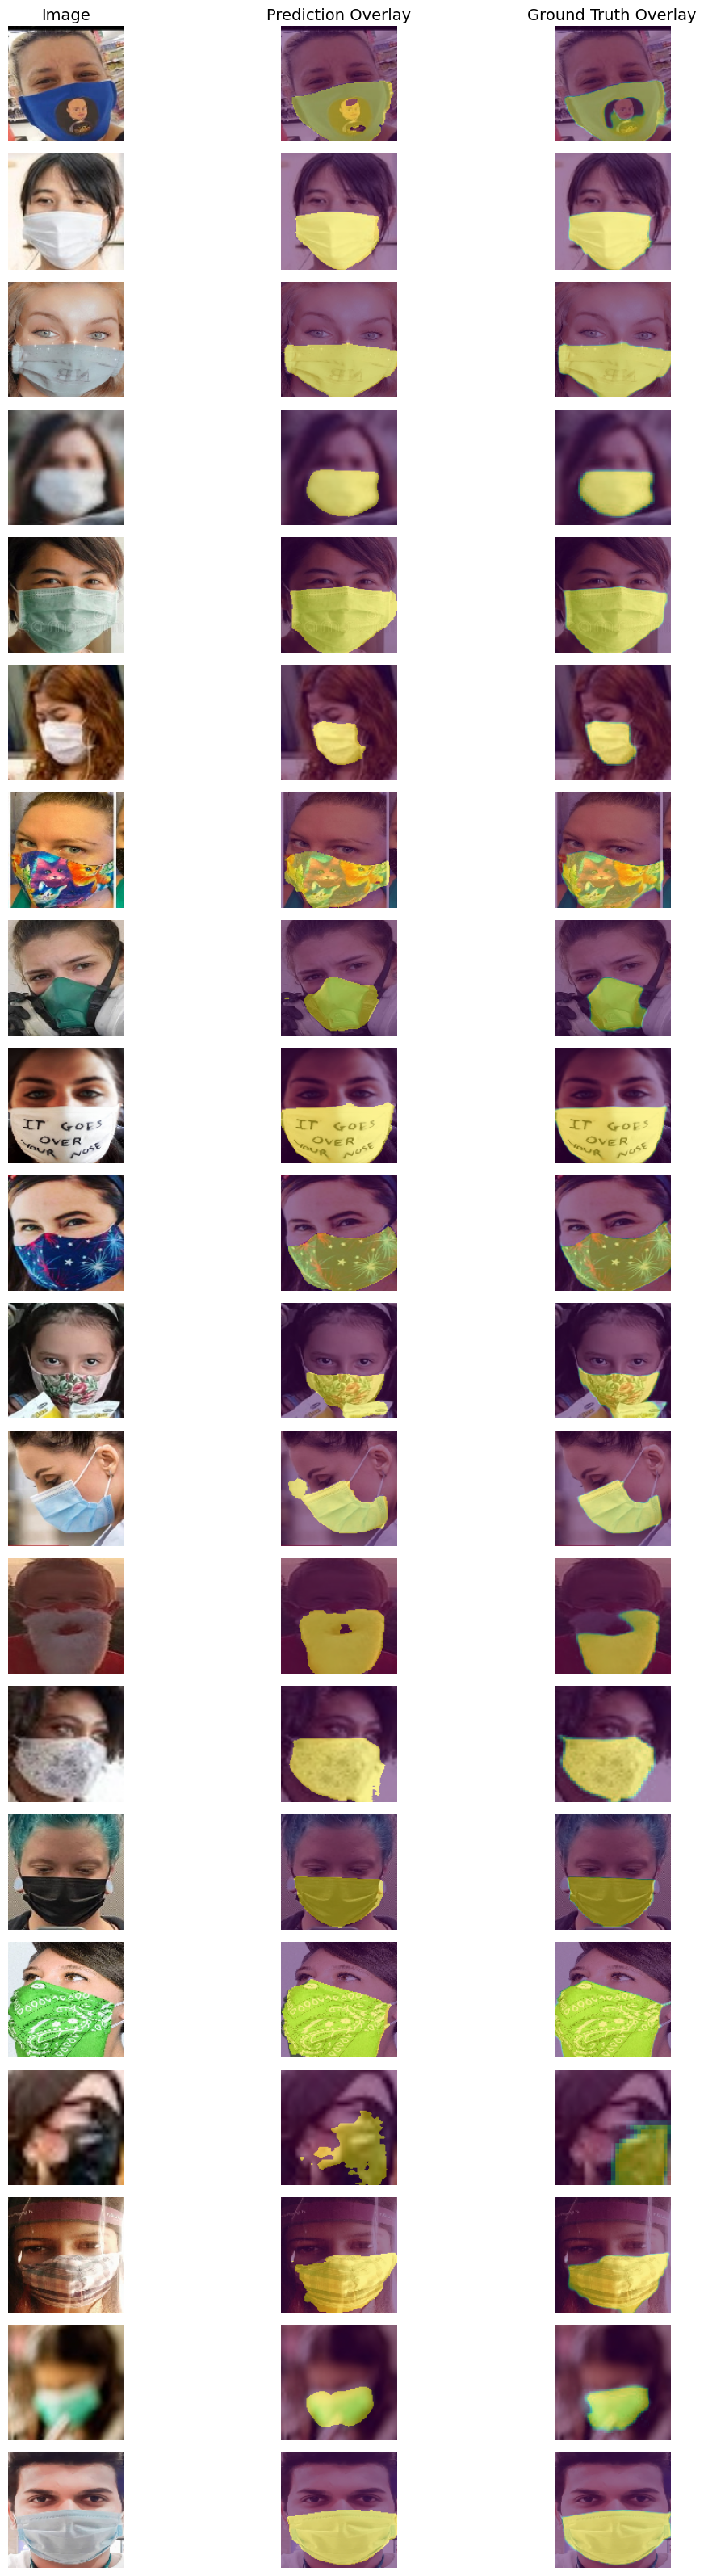

In [18]:
# Get a batch of images from validation set and create grid of image and predictions together
def create_prediction_grid(model, data_loader, device='cuda'):
    imgs, segs = next(iter(data_loader))
    imgs = imgs.to(device)
    segs = segs.to(device)

    with torch.no_grad():
        preds = model(imgs)
        _, preds = preds.max(1)

    # Denormalize images
    imgs = imgs * torch.tensor([0.25698626, 0.23935081, 0.23180752], device=device).view(1, 3, 1, 1) + \
           torch.tensor([0.52988076, 0.45696659, 0.43334861], device=device).view(1, 3, 1, 1)

    # Plot images, predictions, and overlaid masks
    fig, axs = plt.subplots(20, 3, figsize=(12, 32))

    column_titles = ["Image", "Prediction Overlay", "Ground Truth Overlay"]
    for ax, title in zip(axs[0], column_titles):
        ax.set_title(title, fontsize=14)

    for i in range(20):
        # Original image
        axs[i, 0].imshow(imgs[i].permute(1, 2, 0).cpu().numpy())
        axs[i, 0].axis('off')
        # Overlay prediction mask on image
        axs[i, 1].imshow(imgs[i].permute(1, 2, 0).cpu().numpy())  # Background image
        axs[i, 1].imshow(preds[i].cpu().numpy(), cmap='viridis', alpha=0.5)  # Overlay predicted mask
        axs[i, 1].axis('off')

        # Overlay ground truth segmentation mask on image
        axs[i, 2].imshow(imgs[i].permute(1, 2, 0).cpu().numpy())  # Background image
        axs[i, 2].imshow(segs[i].cpu().numpy(), cmap='viridis', alpha=0.5)  # Overlay ground truth mask
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

create_prediction_grid(model, val_loader)

In [ ]:
image_paths = os.listdir("MSFD/1/face_crop")                # Images on which segmentation is performed
ground_truths = os.listdir("MSFD/1/face_crop_segmentation") # Ground truth segmented images

In [ ]:
# Initialize output directory

if os.path.exists("Output/PartC"):

    for file in os.listdir("Output/PartC"): 
        file_path = os.path.join("Output/PartC", file)

        if os.path.isfile(file_path):
            os.unlink(file_path)

else:
    os.makedirs("Output/PartC")

In [ ]:
# Function to evaluate segmentation result (IoU score)
def evaluate(segment, ground_truth):
    
    intersection = ((segment > 0) & (ground_truth > 0)).sum()
    union = ((segment > 0) | (ground_truth > 0)).sum() + 1e-8        
    iou = (intersection / union).mean()

    return iou

In [ ]:
image_num = 1
sum_iou = 0   # Sum of IoU

# Iterate through required number of images
for index in range(min(500, len(image_paths))):

    image_path = image_paths[index]          
    ground_truth_path = ground_truths[index] 

    print(f"Processing Image {image_num}...")

    image = cv2.imread("MSFD/1/face_crop/" + image_path)                     # Input image
    ground_truth = cv2.imread("MSFD/1/face_crop_segmentation/" + image_path) # Ground truth

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0.5) # Apply Gaussian filter

    # Detect edges and find contours
    edges = cv2.Canny(blurred_image, threshold1=20, threshold2=100)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    image_width, image_height = image.shape[:2] # Dimensions of image
    
    # Candidates for segmentation outputs
    segmented_image1 = np.zeros([image_width, image_height, 3], dtype=float)
    segmented_image2 = np.zeros([image_width, image_height, 3], dtype=float)
    
    for cnt in contours:

        x, y, w, h = cv2.boundingRect(cnt) # Bounding box for the contour
        
        # Perform binary + inverse binary thresholding on the part of image within bounding box
        _, inv_binary_segment = cv2.threshold(blurred_image[y: y + h, x: x + w], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        _, binary_segment = cv2.threshold(blurred_image[y: y + h, x: x + w], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Add the thresholded image to candidate outputs
        for i in range(y, y + h):
            for j in range(x, x + w):
                segmented_image1[i][j] += binary_segment[i - y][j - x]
                segmented_image2[i][j] += inv_binary_segment[i - y][j - x]

    cut = int(0.6 * image_height) # To make the upper part of image as black

    segmented_image1[: cut, :, :] = 0
    segmented_image2[: cut, :, :] = 0
    
    # Calculate number of white prixels in both images (White pixels represent mask region)
    sum_lower1 = segmented_image1.sum()
    sum_lower2 = segmented_image2.sum()

    # Save the image which has a higher number of white pixels
    # Calculate the corresponding IoU score

    if sum_lower1 > sum_lower2:
        cv2.imwrite(f"Output/PartC/{image_path}.png", segmented_image1)
        sum_iou += evaluate(segmented_image1, ground_truth)

    else:
        cv2.imwrite(f"Output/PartC/{image_path}.png", segmented_image2)
        sum_iou += evaluate(segmented_image2, ground_truth)

    print(f"Image {image_num} processed.")
    image_num += 1

print(sum_iou / (image_num - 1)) # Average IoU
